# Hallucination Evaluation


## MCQA
we import: from hallucination_eval import evaluate_hallucination this function implements the Multiple Choice agent based hallucination evaluation.

In [ ]:
import pandas as pd
df_mexico = pd.read_csv("/Users/hannes/Documents/master_thesis/acled_mexico_2025.csv")
df_myanmar = pd.read_csv("/Users/hannes/Documents/master_thesis/acled_myanmar_2025.csv")
df_sudan = pd.read_csv("/Users/hannes/Documents/master_thesis/acled_sudan_2025.csv")
df_georgia = pd.read_csv("/Users/hannes/Documents/master_thesis/acled_georgia_2025.csv")
df_congo = pd.read_csv("/Users/hannes/Documents/master_thesis/acled_democratic republic of congo_2025.csv")

In [3]:
df_list = [df_mexico, df_myanmar, df_sudan, df_georgia, df_congo]

In [4]:
for df in df_list:

    df["event_date"] = pd.to_datetime(df["event_date"])
    df["year"]   = df["event_date"].dt.year.astype(int)
    df["month"]  = df["event_date"].dt.month.astype(int)
    df["day"]    = df["event_date"].dt.day.astype(int)
    df["date_int"] = df["event_date"].dt.strftime("%Y%m%d").astype(int)


In [5]:
# count rows in each dataframe per month per event type
def count_rows_per_month(df, event_type):
    return df[df["event_type"] == event_type].groupby(["year", "month"]).size().reset_index(name="count")

# create a dictionary to hold the counts for each event type
event_types = df_list[0]["event_type"].unique()
event_counts = {et: pd.DataFrame() for et in event_types}
# count rows for each event type in each dataframe
for df in df_list:
    for et in event_types:
        counts = count_rows_per_month(df, et)
        counts["country"] = df["country"].iloc[0]  # add country name
        event_counts[et] = pd.concat([event_counts[et], counts], ignore_index=True)
# merge all event type counts into a single dataframe
merged_counts = pd.DataFrame()
for et, counts in event_counts.items():
    counts = counts.rename(columns={"count": f"{et}_count"})
    if merged_counts.empty:
        merged_counts = counts
    else:
        merged_counts = pd.merge(merged_counts, counts, on=["year", "month", "country"], how="outer")

In [ ]:
merged_counts

In [ ]:
# bulk_eval_len.py  –  hallucination vs. information length
# ---------------------------------------------------------
import pandas as pd
import acled_tools as at
from hallucination_eval import evaluate_hallucination

URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

# ── configuration ────────────────────────────────────────────────────
COUNTRIES   = ["Democratic Republic of Congo",
               "Mexico",
               "Georgia",
               "Myanmar",
               "Sudan"]

MONTHS      = range(1, 7)     # Jan … Jul
EVENT_FUNCS = {
    "Violence against civilians": at.summarize_vac,
    "Protests"                  : at.summarize_protests,
    "Riots"                     : at.summarize_riots,
    "Battles"                   : at.summarize_battles,
    "Strategic developments"    : at.summarize_strategic,
}

MCQ_N      = 10          # questions per summary
ITERATIONS = 5           # answer/grade passes
TEMP_GEN   = 0.3         # generation temperature
MAX_TOK    = 900

# ── helper: count events for one slice ───────────────────────────────
def slice_size(uri, user, pwd, *, country, year, month, event_type):
    """Return number of events in the (country,year,month,event_type) slice."""
    q = """
    MATCH (e:Event)-[:TYPE]->(t:EventType),
          (e)-[:IN_STATE]->(s:State)
    WHERE e.year=$y AND e.month=$m
      AND s.country=$c
      AND t.code=$et
    RETURN count(e) AS n
    """
    with at.GraphDatabase.driver(uri, auth=(user, pwd)).session() as sess:
        return sess.run(q, y=year, m=month, c=country, et=event_type).single()["n"]

# ── main loop ────────────────────────────────────────────────────────
records = []
for country in COUNTRIES:
    print(f"\n===== {country.upper()} =====")
    prev_ctx = {et: "" for et in EVENT_FUNCS}   # keep last-month context

    for month in MONTHS:
        print(f"—— {month:02d}/2025 ——")
        for et, fn in EVENT_FUNCS.items():

            # 1) Generate summary **with** previous-month context
            summary, bullets, _ , metrics = fn(
                uri   = URI, user = USER, pwd = PWD,
                country = country, year = 2025, month = month,
                context = prev_ctx[et],     # enables context-aware template
                check_citations = False,
                temperature = TEMP_GEN, max_tokens = MAX_TOK
            )
            prev_ctx[et] = summary         # stash for next loop

            # 2) Evaluate hallucinations (give evaluator the same context!)
            corpus = (
                bullets +
                "\n\nHEADLINE METRICS:\n" + metrics +
                "\n\nPREVIOUS-MONTH SUMMARY:\n" + (prev_ctx[et] or "")
            )
            eval_stats = evaluate_hallucination(
                summary    = summary,
                corpus     = corpus,
                total_q    = MCQ_N,
                iterations = ITERATIONS,
                temp_q     = 0.0,
                temp_a     = 0.0
            )

            # 3) Store: hallucination + information length
            records.append({
                "country"           : country,
                "month"             : month,
                "event_type"        : et,
                "info_length"       : slice_size(URI, USER, PWD,
                                                 country=country,
                                                 year=2025, month=month,
                                                 event_type=et),
                **eval_stats        # hallucination_rate, questions, …
            })

# ── final dataframe & save ───────────────────────────────────────────
df = pd.DataFrame(records)
df.to_csv("hallucination_vs_length.csv", index=False)

print("\nSaved → hallucination_vs_length.csv")
print(df.head())

In [ ]:
# ╔═══════════════════════════════════════╗
# ║   bulk_eval_nocontext.py             ║
# ╚═══════════════════════════════════════╝
import pandas as pd
import acled_tools as at
from hallucination_eval import evaluate_hallucination

URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

COUNTRIES  = ["Democratic Republic of Congo",
              "Mexico",
              "Georgia",
              "Myanmar",
              "Sudan"]

MONTHS     = range(1, 7)     # Jan … Jul 2025
EVENT_FUNCS = {
    "Violence against civilians": at.summarize_vac,
    "Protests"                  : at.summarize_protests,
    "Riots"                     : at.summarize_riots,
    "Battles"                   : at.summarize_battles,
    "Strategic developments"    : at.summarize_strategic,
}

MCQ_N       = 10          # questions / evaluation
ITERATIONS  = 7          # answer/grade passes
TEMP_GEN    = 0.3         # summary generation temperature
MAX_TOK     = 900

# helper – number of events (information load)
def slice_size(uri, user, pwd, *, country, year, month, etype):
    q = """
    MATCH (e:Event)-[:TYPE]->(t:EventType),
          (e)-[:IN_STATE]->(s:State)
    WHERE e.year=$y AND e.month=$m AND s.country=$c AND t.code=$t
    RETURN count(e) AS n
    """
    with at.GraphDatabase.driver(uri, auth=(user, pwd)).session() as ss:
        return ss.run(q, y=year, m=month, c=country, t=etype).single()["n"]

records = []

for country in COUNTRIES:
    print(f"\n========= {country.upper()} =========")
    for mo in MONTHS:
        print(f"—— {mo:02d}/2025 ——")
        for et, fn in EVENT_FUNCS.items():

            # 1) summary generation  (NO previous context)
            summ, bullets, _ , metrics = fn(
                uri=URI, user=USER, pwd=PWD,
                country=country, year=2025, month=mo,
                context="",                    # ← no context!
                check_citations=False,
                temperature=TEMP_GEN, max_tokens=MAX_TOK
            )

            # 2) hallucination eval (MCQ accuracy)
            eval_out = evaluate_hallucination(
                summary    = summ,
                corpus     = bullets + "\n\nHEADLINE METRICS:\n" + metrics,
                total_q    = MCQ_N,
                iterations = ITERATIONS,
                temp_q=0.0, temp_a=0.0
            )

            # 3) store result row
            records.append({
                "country"      : country,
                "month"        : mo,
                "event_type"   : et,
                "info_length"  : slice_size(URI, USER, PWD,
                                            country=country,
                                            year=2025, month=mo,
                                            etype=et),
                **eval_out     # hallucination_rate, questions, avg_correct, …
            })

# 4) save & preview
df_nc = pd.DataFrame(records)
df_nc.to_csv("hallucination_nocontext.csv", index=False)

print("\nSaved → hallucination_nocontext.csv")
print(df_nc.head())


========= DEMOCRATIC REPUBLIC OF CONGO =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= MEXICO =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= GEORGIA =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= MYANMAR =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= SUDAN =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

Saved → hallucination_nocontext.csv
                        country  month                  event_type  \
0  Democratic Republic of Congo      1  Violence against civilians   
1  Democratic Republic of Congo      1                    Protests   
2  Democratic Republic of Congo      1                       Riots   
3  Democratic Republic of Congo      1                     Battles   
4  Democratic Republic of Cong

### with context

In [ ]:
# ╔═══════════════════════════════════════╗
# ║   bulk_eval_context.py               ║
# ╚═══════════════════════════════════════╝
import pandas as pd
import acled_tools as at
from hallucination_eval import evaluate_hallucination

URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

# ---------------------------------------------------------------------
COUNTRIES  = [
    "Democratic Republic of Congo",
    "Mexico",
    "Georgia",
    "Myanmar",
    "Sudan",
]

MONTHS       = range(1, 7)     # Jan … Jul 2025
EVENT_FUNCS  = {
    "Violence against civilians": at.summarize_vac,
    "Protests"                  : at.summarize_protests,
    "Riots"                     : at.summarize_riots,
    "Battles"                   : at.summarize_battles,
    "Strategic developments"    : at.summarize_strategic,
}

MCQ_N        = 10           # questions per evaluation
ITERATIONS   = 7           # answer/grade passes
TEMP_GEN     = 0.3          # temperature for summary generation
MAX_TOK      = 900          # token cap for summaries

# ---------------------------------------------------------------------
# helper – number of events (information load)
def slice_size(uri, user, pwd, *, country, year, month, etype):
    q = """
    MATCH (e:Event)-[:TYPE]->(t:EventType),
          (e)-[:IN_STATE]->(s:State)
    WHERE e.year=$y AND e.month=$m
      AND s.country=$c AND t.code=$t
    RETURN count(e) AS n
    """
    with at.GraphDatabase.driver(uri, auth=(user, pwd)).session() as ss:
        return ss.run(q, y=year, m=month, c=country, t=etype).single()["n"]

# ---------------------------------------------------------------------
records = []

for country in COUNTRIES:
    print(f"\n========= {country.upper()} =========")

    # keep previous-month summary per event-type for this country
    last_summary = {et: "" for et in EVENT_FUNCS}

    for mo in MONTHS:
        print(f"—— {mo:02d}/2025 ——")
        for et, fn in EVENT_FUNCS.items():

            prev_ctx = last_summary[et]       # may be empty for Jan

            # 1) summary generation WITH context
            summ, bullets, _ , metrics = fn(
                uri=URI, user=USER, pwd=PWD,
                country=country, year=2025, month=mo,
                context=prev_ctx,              # ← supply context
                check_citations=False,
                temperature=TEMP_GEN,
                max_tokens=MAX_TOK
            )
            # stash for next month
            last_summary[et] = summ

            # 2) hallucination eval – give the evaluator the *same* context
            corpus = (
                bullets
                + "\n\nHEADLINE METRICS:\n" + metrics
                + ("\n\nPREVIOUS-MONTH SUMMARY:\n" + prev_ctx if prev_ctx else "")
            )

            eval_out = evaluate_hallucination(
                summary      = summ,
                corpus       = corpus,
                total_q      = MCQ_N,
                iterations   = ITERATIONS,
                temp_q       = 0.0,
                temp_a       = 0.0
            )

            # 3) collect
            records.append({
                "country"      : country,
                "month"        : mo,
                "event_type"   : et,
                "info_length"  : slice_size(
                                    URI, USER, PWD,
                                    country=country,
                                    year=2025, month=mo,
                                    etype=et),
                **eval_out
            })

# ---------------------------------------------------------------------
df_ctx = pd.DataFrame(records)
df_ctx.to_csv("hallucination_with_context.csv", index=False)

print("\nSaved → hallucination_with_context.csv")
print(df_ctx.head())


========= DEMOCRATIC REPUBLIC OF CONGO =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= MEXICO =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= GEORGIA =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= MYANMAR =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

========= SUDAN =========
—— 01/2025 ——
—— 02/2025 ——
—— 03/2025 ——
—— 04/2025 ——
—— 05/2025 ——
—— 06/2025 ——

Saved → hallucination_with_context.csv
                        country  month                  event_type  \
0  Democratic Republic of Congo      1  Violence against civilians   
1  Democratic Republic of Congo      1                    Protests   
2  Democratic Republic of Congo      1                       Riots   
3  Democratic Republic of Congo      1                     Battles   
4  Democratic Republic of C

## Citation Check
the function citation check is integrated in each summarisation function, documentation in acled_tools.py


In [1]:
# generate summary for congo protests march 2025
import acled_tools as at
from hallucination_eval import evaluate_hallucination
URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"
country = "Mexico"
year = 2025
month = 3
event_type = "Battles"
summary, bullets, _ , metrics = at.summarize_battles(
    uri=URI, user=USER, pwd=PWD,
    country=country, year=year, month=month,
    context="",  # no context
    check_citations=False,
    temperature=0.3, max_tokens=900
)
citation_report = at.verify_citations_from_bullets(
    summary_text=summary,
    bullets_blob=bullets,
    return_extras=False        # optional – see what wasn’t cited
)
print("Summary:", summary)
print("\nCitation report:", citation_report)

cited_bullets = at.extract_citations(summary, bullets)



Cited IDs : 15  •  Matched : 15
✅ all cited IDs present in bullets.
Summary: **Conflict Early-Warning Brief: Battles Across Mexico (March 2025)**

**Headline Figures:**
- Total battles: **145**
- Armed clashes: **145** (155 fatalities)
- No territorial gains by government or non-state actors.

**Summary:**
March 2025 saw sustained armed clashes across Mexico, with **145 incidents** resulting in **155 fatalities**. Most clashes involved rival criminal groups, security forces, or a combination of both. Key themes included territorial disputes, cartel infighting, and attacks on law enforcement. Sinaloa, Jalisco, Michoacán, and Nuevo León were hotspots, with Sinaloa experiencing the highest number of clashes (20+ events).

**Key Developments:**
1. **Cartel Dominance:**
   - The **Jalisco New Generation Cartel (CJNG)** was involved in multiple clashes, particularly in Michoacán (e.g., MEX101398, MEX101432) and Jalisco (MEX101398, MEX101406).
   - **Sinaloa Cartel factions** (e.g., Los Chapi

### Get the bullets that correspond to the ids

In [2]:
print(f"Found {len(cited_bullets)} cited bullets:\n")
for bid, block in cited_bullets.items():
    print(f"{bid}\n{block}\n{'-'*80}")

Found 15 cited bullets:

MEX101571
- ID: MEX101571 | Sinaloa | Armed clash | On 15 March 2025, in Tomo, Sinaloa, according to residents, there was an armed clash between members of criminal groups. Houses and vehicles were damaged and drones were used to launch explosives. Local reports indicated that around 12 people were killed, however, this was not confirmed by the authorities. Videos were recorded by residents and shared on social media. The dead body of one of the suspected participants in the clash was found in the area in an advanced state of decomposition and with tactical clothing and equipment around 28 March 2025. Around 12 fatalities.
--------------------------------------------------------------------------------
MEX100666
- ID: MEX100666 | Puebla | Armed clash | Around 1 March 2025 (between 27 February - 2 March), in San Jose Miahuatlan, Puebla, nine members of a criminal group from Tlaxcala (five men and four women) were killed and their dismembered bodies were found wi

## Run Citation Check on large sample of summaries to collect statistics

In [1]:
import time, random, functools, requests
from requests.exceptions import HTTPError, ConnectionError, Timeout
import acled_tools as at

# ── 1 · skip patching if already wrapped ────────────────────────────────
if getattr(at.ask_llm, "_retry_wrapper_installed", False):
    print("ask_llm already has retry wrapper – skipping re-patch.")
else:
    # grab the genuine underlying function (even if someone wrapped before)
    _BASE_ASK = getattr(at.ask_llm, "__wrapped__", at.ask_llm)

    @functools.wraps(_BASE_ASK)
    def ask_llm_retry(*args, max_attempts: int = 6, **kwargs):
        """
        Retry `acled_tools.ask_llm` on 429, 5xx, or transient network errors
        with exponential back-off (1s, 2s, 4s …).
        """
        backoff = 1.0
        for attempt in range(max_attempts):
            try:
                return _BASE_ASK(*args, **kwargs)

            except HTTPError as e:
                status = e.response.status_code if e.response else None
                if status in {429, 500, 502, 503, 504} and attempt < max_attempts - 1:
                    wait = backoff + random.uniform(0, 0.5)
                    print(f"[WARN] HTTP {status} – retry {attempt+1}/{max_attempts}"
                          f" after {wait:.1f}s")
                else:
                    raise

            except (ConnectionError, Timeout):
                if attempt < max_attempts - 1:
                    wait = backoff + random.uniform(0, 0.5)
                    print(f"[WARN] network error – retry {attempt+1}/{max_attempts}"
                          f" after {wait:.1f}s")
                else:
                    raise

            time.sleep(wait)
            backoff *= 2

    # flag + unwrap handle
    ask_llm_retry._retry_wrapper_installed = True
    ask_llm_retry.__wrapped__ = _BASE_ASK

    # monkey-patch once
    at.ask_llm = ask_llm_retry
    print("Retry wrapper installed on acled_tools.ask_llm")

Retry wrapper installed on acled_tools.ask_llm


In [2]:
import re
"""
run_citation_tests.py  –  sweep all slices and report citation quality
----------------------------------------------------------------------
Prereqs
 • acled_tools (your wrapper)
 • verify_citations_from_bullets (local helper, see utils.py)
 • pandas (only for the final summary table)
"""

from pathlib import Path
from datetime import datetime
import pandas as pd

import acled_tools as at # <- put helper there

# ─────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────
URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

COUNTRIES = [
    "Democratic Republic of Congo",
    "Mexico",
    "Georgia",
    "Myanmar",
    "Sudan",
]

MONTHS = range(1, 7)           # Jan–Jun 2025  (range is [1,6])
YEAR   = 2025

EVENT_FUNCS = {
    "Violence against civilians": at.summarize_vac,
    "Protests"                  : at.summarize_protests,
    "Riots"                     : at.summarize_riots,
    "Battles"                   : at.summarize_battles,
    "Strategic developments"    : at.summarize_strategic,
}

OUT = []                       # list of per-run dicts
# ─────────────────────────────────────────────────────────────
# MAIN LOOP
# ─────────────────────────────────────────────────────────────
for country in COUNTRIES:
    for month in MONTHS:
        for etype, func in EVENT_FUNCS.items():

            print(f"[{datetime.now():%H:%M:%S}]  {country:30s} "
                  f"{YEAR}-{month:02d}  {etype}")

            # 1) generate summary
            summary, bullets, _, _ = func(
                uri=URI, user=USER, pwd=PWD,
                country=country,
                year=YEAR,
                month=month,
                context="",
                check_citations=False,   # we'll verify ourselves
                temperature=0.3,
                max_tokens=900,
            )

            # 2) citation check
            rep = at.verify_citations_from_bullets(
                summary_text=summary,
                bullets_blob=bullets,
                return_extras=False,
            )

            # 3) record stats
            tot_cited = len(set(re.findall(r'\b[A-Z]{2,}[0-9]{2,}\b', summary)))
            out = {
                "country"      : country,
                "month"        : month,
                "event_type"   : etype,
                "total_cited"  : tot_cited,
                "missing"      : len(rep["missing"]),
                "missing_ids"  : ", ".join(rep["missing"]),
            }
            OUT.append(out)

# ─────────────────────────────────────────────────────────────
# SUMMARY TABLE
# ─────────────────────────────────────────────────────────────
df = pd.DataFrame(OUT)
df["missing_rate"] = df["missing"] / df["total_cited"].clip(lower=1)

# save full per-run log
Path("citation_runs.csv").write_text(df.to_csv(index=False))
print("\nSaved per-run details to citation_runs.csv")

# quick aggregate view
agg = (df.groupby(["event_type"])
         .agg(total_runs   = ("country", "size"),
              cited_total   = ("total_cited", "sum"),
              missing_total = ("missing", "sum"))
         .assign(missing_rate = lambda x: x.missing_total / x.cited_total))

print("\n=== Aggregate by event type ===")
print(agg.to_string(float_format="%.3f"))

[12:10:35]  Democratic Republic of Congo   2025-01  Violence against civilians
Cited IDs : 20  •  Matched : 20
✅ all cited IDs present in bullets.
[12:11:39]  Democratic Republic of Congo   2025-01  Protests
Cited IDs : 18  •  Matched : 18
✅ all cited IDs present in bullets.
[12:13:08]  Democratic Republic of Congo   2025-01  Riots
Cited IDs : 13  •  Matched : 13
✅ all cited IDs present in bullets.
[12:13:35]  Democratic Republic of Congo   2025-01  Battles
Cited IDs : 23  •  Matched : 23
✅ all cited IDs present in bullets.
[12:14:42]  Democratic Republic of Congo   2025-01  Strategic developments
Cited IDs : 24  •  Matched : 24
✅ all cited IDs present in bullets.
[12:15:12]  Democratic Republic of Congo   2025-02  Violence against civilians
Cited IDs : 16  •  Matched : 16
✅ all cited IDs present in bullets.
[12:15:52]  Democratic Republic of Congo   2025-02  Protests
Cited IDs : 13  •  Matched : 13
✅ all cited IDs present in bullets.
[12:16:22]  Democratic Republic of Congo   2025-02 

In [16]:
# ░░ add-info-length.py  ░░
# ---------------------------------------------------------------
import pandas as pd
import acled_tools as at     # needs `GraphDatabase` inside
from pathlib import Path

URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

# -- 1) load existing citation results ---------------------------------
df = pd.read_csv("citation_runs.csv")   # ← file from the previous run

# -- 2) helper to count events in a slice ------------------------------
def slice_size(country, year, month, etype):
    q = """
    MATCH (e:Event)-[:TYPE]->(t:EventType),
          (e)-[:IN_STATE]->(:State {country:$c})
    WHERE e.year=$y AND e.month=$m AND t.code=$t
    RETURN count(e) AS n
    """
    with at.GraphDatabase.driver(URI, auth=(USER, PWD)).session() as s:
        return s.run(q, c=country, y=year, m=month, t=etype).single()["n"]

# -- 3) compute info_length for every row ------------------------------
print("Counting events for", len(df), "slices …")
df["info_length"] = [
    slice_size(r.country, 2025, r.month, r.event_type)
    for r in df.itertuples()
]

# -- 4) recompute missing-rate (just in case) --------------------------
df["missing_rate"] = df["missing"] / df["total_cited"].clip(lower=1)

# -- 5) save & quick peek ---------------------------------------------
Path("citation_with_length.csv").write_text(df.to_csv(index=False))
print("\n✅  Saved → citation_with_length.csv")
print(df.head())

Counting events for 150 slices …

✅  Saved → citation_with_length.csv
                        country  month                  event_type  \
0  Democratic Republic of Congo      1  Violence against civilians   
1  Democratic Republic of Congo      1                    Protests   
2  Democratic Republic of Congo      1                       Riots   
3  Democratic Republic of Congo      1                     Battles   
4  Democratic Republic of Congo      1      Strategic developments   

   total_cited  missing missing_ids  missing_rate  info_length  
0           20        0         NaN           0.0           67  
1           18        0         NaN           0.0           29  
2           13        0         NaN           0.0           15  
3           23        0         NaN           0.0          200  
4           24        0         NaN           0.0           93  


/var/folders/yl/blfh275s3xq56mz3wkmfnrzh0000gn/T/ipykernel_6537/1169776590.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), loc="upper left")


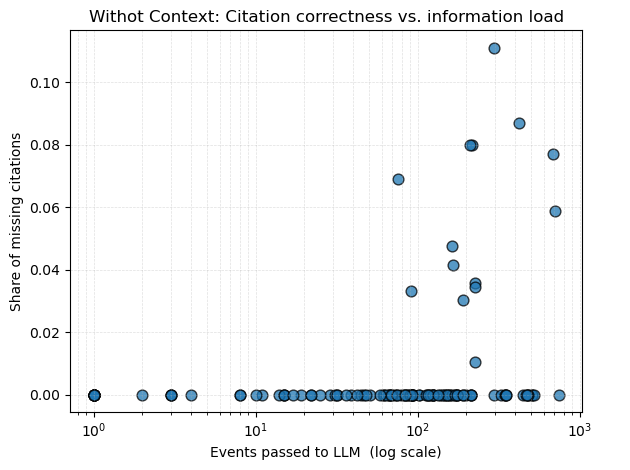

In [23]:
# ░░ visualize_citation_vs_load.py ░░
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 1) load the data produced in the previous step
df = pd.read_csv("citation_with_length.csv")

   # 10 nice colours


plt.scatter(
        df["info_length"],
        df["missing_rate"],
        alpha=0.75,
        edgecolor="k",
        s=60,
    )

plt.xscale("log")                           # counts span 10¹–10³ → log helps
plt.xlabel("Events passed to LLM  (log scale)")
plt.ylabel("Share of missing citations")
plt.title("Withot Context: Citation correctness vs. information load")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)

plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()

plt.show()

In [15]:
# ░░ cite_stats.py ░░
# -----------------------------------------------------------
import pandas as pd

df = pd.read_csv("citation_with_length.csv")

# ----- global figures --------------------------------------
total_runs        = len(df)
runs_perfect      = (df["missing"] == 0).sum()
share_perfect     = runs_perfect / total_runs
total_cited       = int(df["total_cited"].sum())
total_missing     = int(df["missing"].sum())
avg_missing_rate  = (df["missing"].sum() / df["total_cited"].clip(lower=1).sum())

print("=== GLOBAL CITATION STATS ===")
print(f"• Evaluations run          : {total_runs}")
print(f"• Perfect citations (0 err): {runs_perfect}  "
      f"({share_perfect:.1%})")
print(f"• Total IDs cited          : {total_cited}")
print(f"• IDs not found            : {total_missing} "
      f"({avg_missing_rate:.2%} of all citations)")

# ----- breakdown by event-type ------------------------------
by_et = (df.groupby("event_type")
           .agg(runs            = ("country", "size"),
                perfect_runs    = ("missing", lambda x: (x == 0).sum()),
                cited_total     = ("total_cited", "sum"),
                missing_total   = ("missing", "sum"))
           .assign(perfect_rate = lambda x: x.perfect_runs / x.runs,
                   missing_rate = lambda x: x.missing_total / x.cited_total))

# … previous code unchanged …

print("\n=== BY EVENT TYPE ===")
tmp = by_et.copy()
# format the two rate columns as percentage strings
for col in ["perfect_rate", "missing_rate"]:
    tmp[col] = (tmp[col] * 100).round(1).astype(str) + " %"

print(tmp.to_string())

=== GLOBAL CITATION STATS ===
• Evaluations run          : 125
• Perfect citations (0 err): 83  (66.4%)
• Total IDs cited          : 1958
• IDs not found            : 211 (10.71% of all citations)

=== BY EVENT TYPE ===
                            runs  perfect_runs  cited_total  missing_total perfect_rate missing_rate
event_type                                                                                          
Battles                       25            19          351             63       76.0 %       17.9 %
Protests                      25            15          492             61       60.0 %       12.4 %
Riots                         25            15          196             12       60.0 %        6.1 %
Strategic developments        25            14          554             40       56.0 %        7.2 %
Violence against civilians    25            20          365             35       80.0 %        9.6 %



=== BY EVENT TYPE ===
                            runs  perfect_runs  cited_total  missing_total perfect_rate missing_rate
event_type                                                                                          
Battles                       30            29          433              6       96.7 %        1.4 %
Protests                      30            27          410              4       90.0 %        1.0 %
Riots                         30            30          185              0      100.0 %        0.0 %
Strategic developments        30            20          667             13       66.7 %        1.9 %
Violence against civilians    30            30          384              0      100.0 %        0.0 %


In [1]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  citation_sweep_with_context.py – robust version                 ║
# ╚══════════════════════════════════════════════════════════════════╝
import re, time, random, csv
from datetime import datetime
from pathlib import Path
from typing import Callable, Any

import pandas as pd
import requests  # for catching network errors

import acled_tools as at   # ← your helper module with summarise_xxx wrappers
# ──────────────────────────────────────────────────────────────────────────
# 1) CONFIG
# ──────────────────────────────────────────────────────────────────────────
URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

COUNTRIES = [
    "Democratic Republic of Congo",
    "Mexico",
    "Georgia",
    "Myanmar",
    "Sudan",
]
YEAR        = 2025
MONTHS      = range(1, 6)            # Jan … May 2025
MAX_TOKENS  = 900
TEMP_GEN    = 0.3

EVENT_FUNCS = {
    "Violence against civilians": at.summarize_vac,
    "Protests"                  : at.summarize_protests,
    "Riots"                     : at.summarize_riots,
    "Battles"                   : at.summarize_battles,
    "Strategic developments"    : at.summarize_strategic,
}

CSV_PATH = Path("citation_runs_with_context.csv")
TMP_PATH = CSV_PATH.with_suffix(".partial.csv")   # incremental write

# ──────────────────────────────────────────────────────────────────────────
# 2) Helper: robust API call with retry / back-off
# ──────────────────────────────────────────────────────────────────────────
def call_with_retry(fn: Callable[..., Any],
                    *,
                    retries: int = 4,
                    base_wait: float = 3.0,
                    **kwargs):
    """
    Wrap any function that may raise HTTP 429 / network errors.
    Exponential back-off   wait = base_wait * 2**attempt  (+/- jitter)
    """
    for attempt in range(retries):
        try:
            return fn(**kwargs)
        except requests.exceptions.HTTPError as e:
            # Only retry on 429 or 5xx
            status = e.response.status_code
            if status not in (429, 502, 503, 504) or attempt == retries - 1:
                raise
            wait = base_wait * (2 ** attempt) * random.uniform(0.8, 1.2)
            print(f"[{datetime.now():%H:%M:%S}]  Rate-limited ({status}). "
                  f"Sleeping {wait:.1f}s and retrying…")
            time.sleep(wait)
        except requests.exceptions.RequestException as e:
            # transient network glitch
            if attempt == retries - 1:
                raise
            wait = base_wait * (2 ** attempt) * random.uniform(0.8, 1.2)
            print(f"[{datetime.now():%H:%M:%S}]  Net error: {e}. "
                  f"Retrying in {wait:.1f}s…")
            time.sleep(wait)

# ──────────────────────────────────────────────────────────────────────────
# 3) Initialise state
# ──────────────────────────────────────────────────────────────────────────
last_summary = {(c, et): "" for c in COUNTRIES for et in EVENT_FUNCS}
written_header = TMP_PATH.exists()

# open CSV in append-mode for incremental writes
csv_fh = TMP_PATH.open("a", newline="", encoding="utf-8")
csv_writer = csv.DictWriter(csv_fh,
                            fieldnames=[
                                "country", "month", "event_type",
                                "total_cited", "missing", "missing_ids"
                            ])
if not written_header:
    csv_writer.writeheader()

# ──────────────────────────────────────────────────────────────────────────
# 4) Main sweep
# ──────────────────────────────────────────────────────────────────────────
for country in COUNTRIES:
    for month in MONTHS:
        for etype, func in EVENT_FUNCS.items():

            ctx = last_summary[(country, etype)]
            tag = "ctx" if ctx else "–– "
            print(f"[{datetime.now():%H:%M:%S}]  "
                  f"{country:30s} {YEAR}-{month:02d}  {etype:<24s} {tag}")

            try:
                # ---- 1) Generate summary (with retry protection) ----
                summary, bullets, *_ = call_with_retry(
                    func,
                    uri=URI, user=USER, pwd=PWD,
                    country=country, year=YEAR, month=month,
                    context=ctx,
                    check_citations=False,
                    temperature=TEMP_GEN, max_tokens=MAX_TOKENS,
                )
            except Exception as e:
                print(f"✖  Skipped slice due to persistent errors → {e}")
                continue                        # go on with next slice

            # stash for next month
            last_summary[(country, etype)] = summary

            # ---- 2) Citation check (always local, no API) ----
            rep = at.verify_citations_from_bullets(
                summary_text=summary,
                bullets_blob=bullets,
                return_extras=False,
            )
            tot_cited = len(set(re.findall(r'\b[A-Z]{2,}[0-9]{2,}\b', summary)))

            row = {
                "country"     : country,
                "month"       : month,
                "event_type"  : etype,
                "total_cited" : tot_cited,
                "missing"     : len(rep["missing"]),
                "missing_ids" : "; ".join(rep["missing"]),
            }

            # incremental write
            csv_writer.writerow(row)
            csv_fh.flush()

# close file handle
csv_fh.close()

# rename partial → final
TMP_PATH.rename(CSV_PATH)
print(f"\n✅  All done. Full log saved to  {CSV_PATH}")

# ──────────────────────────────────────────────────────────────────────────
# 5) Quick aggregate report
# ──────────────────────────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
df["missing_rate"] = df["missing"] / df["total_cited"].clip(lower=1)

agg = (df.groupby("event_type")
         .agg(total_runs   = ("country", "size"),
              cited_total   = ("total_cited", "sum"),
              missing_total = ("missing", "sum"))
         .assign(missing_rate = lambda x: x.missing_total / x.cited_total))

print("\n=== Aggregate by event type (with context) ===")
print(agg.to_string(float_format=lambda x: f"{x:.2f}"))

[18:09:29]  Democratic Republic of Congo   2025-01  Violence against civilians –– 
Cited IDs : 17  •  Matched : 17
✅ all cited IDs present in bullets.
[18:09:43]  Democratic Republic of Congo   2025-01  Protests                 –– 
Cited IDs : 15  •  Matched : 15
✅ all cited IDs present in bullets.
[18:09:47]  Democratic Republic of Congo   2025-01  Riots                    –– 
Cited IDs : 15  •  Matched : 15
✅ all cited IDs present in bullets.
[18:10:28]  Democratic Republic of Congo   2025-01  Battles                  –– 
Cited IDs : 21  •  Matched : 21
✅ all cited IDs present in bullets.
[18:11:19]  Democratic Republic of Congo   2025-01  Strategic developments   –– 
Cited IDs : 28  •  Matched : 28
✅ all cited IDs present in bullets.
[18:11:37]  Democratic Republic of Congo   2025-02  Violence against civilians ctx
Cited IDs : 18  •  Matched : 18
✅ all cited IDs present in bullets.
[18:12:06]  Democratic Republic of Congo   2025-02  Protests                 ctx
Cited IDs : 14  •  Ma

In [3]:
# save to csv
agg.to_csv("citation_aggregate_with_context.csv")
df.to_csv("citation_runs_with_context.csv", index=False)

In [24]:
# ░░ add-info-length.py  ░░
# ---------------------------------------------------------------
import pandas as pd
import acled_tools as at     # needs `GraphDatabase` inside
from pathlib import Path

URI, USER, PWD = "bolt://localhost:7687", "neo4j", "password"

df = pd.read_csv("citation_runs_with_context.csv")  # ← file from the previous run

# -- 2) helper to count events in a slice ------------------------------
def slice_size(country, year, month, etype):
    q = """
    MATCH (e:Event)-[:TYPE]->(t:EventType),
          (e)-[:IN_STATE]->(:State {country:$c})
    WHERE e.year=$y AND e.month=$m AND t.code=$t
    RETURN count(e) AS n
    """
    with at.GraphDatabase.driver(URI, auth=(USER, PWD)).session() as s:
        return s.run(q, c=country, y=year, m=month, t=etype).single()["n"]

# -- 3) compute info_length for every row ------------------------------
print("Counting events for", len(df), "slices …")
df["info_length"] = [
    slice_size(r.country, 2025, r.month, r.event_type)
    for r in df.itertuples()
]

# -- 4) recompute missing-rate (just in case) --------------------------
df["missing_rate"] = df["missing"] / df["total_cited"].clip(lower=1)

# -- 5) save & quick peek ---------------------------------------------
Path("citation_with_length.csv").write_text(df.to_csv(index=False))
print("\n✅  Saved → citation_with_length.csv")
print(df.head())

Counting events for 125 slices …

✅  Saved → citation_with_length.csv
                        country  month                  event_type  \
0  Democratic Republic of Congo      1  Violence against civilians   
1  Democratic Republic of Congo      1                    Protests   
2  Democratic Republic of Congo      1                       Riots   
3  Democratic Republic of Congo      1                     Battles   
4  Democratic Republic of Congo      1      Strategic developments   

   total_cited  missing missing_ids  missing_rate  info_length  
0           17        0         NaN           0.0           67  
1           15        0         NaN           0.0           29  
2           15        0         NaN           0.0           15  
3           21        0         NaN           0.0          200  
4           28        0         NaN           0.0           93  


/var/folders/yl/blfh275s3xq56mz3wkmfnrzh0000gn/T/ipykernel_6537/3352370277.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), loc="upper left")


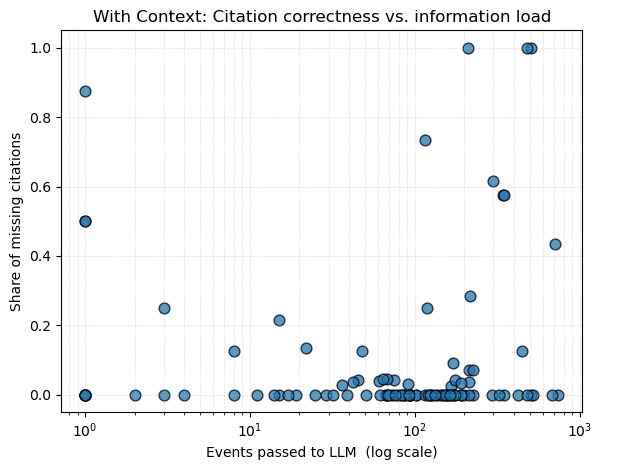

In [26]:
# ░░ visualize_citation_vs_load.py ░░
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 1) load the data produced in the previous step
df = pd.read_csv("citation_with_length.csv")



plt.scatter(
        df["info_length"],
        df["missing_rate"],
        alpha=0.75,
        edgecolor="k",
        s=60,
    )

plt.xscale("log")                           # counts span 10¹–10³ → log helps
plt.xlabel("Events passed to LLM  (log scale)")
plt.ylabel("Share of missing citations")
plt.title("With Context: Citation correctness vs. information load")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)

plt.legend(frameon=False, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [6]:
# ░░ cite_stats.py ░░
# -----------------------------------------------------------
import pandas as pd

df = pd.read_csv("citation_with_length.csv")

# ----- global figures --------------------------------------
total_runs        = len(df)
runs_perfect      = (df["missing"] == 0).sum()
share_perfect     = runs_perfect / total_runs
total_cited       = int(df["total_cited"].sum())
total_missing     = int(df["missing"].sum())
avg_missing_rate  = (df["missing"].sum() / df["total_cited"].clip(lower=1).sum())

print("=== GLOBAL CITATION STATS ===")
print(f"• Evaluations run          : {total_runs}")
print(f"• Perfect citations (0 err): {runs_perfect}  "
      f"({share_perfect:.1%})")
print(f"• Total IDs cited          : {total_cited}")
print(f"• IDs not found            : {total_missing} "
      f"({avg_missing_rate:.2%} of all citations)")

# ----- breakdown by event-type ------------------------------
by_et = (df.groupby("event_type")
           .agg(runs            = ("country", "size"),
                perfect_runs    = ("missing", lambda x: (x == 0).sum()),
                cited_total     = ("total_cited", "sum"),
                missing_total   = ("missing", "sum"))
           .assign(perfect_rate = lambda x: x.perfect_runs / x.runs,
                   missing_rate = lambda x: x.missing_total / x.cited_total))

# … previous code unchanged …

print("\n=== BY EVENT TYPE ===")
tmp = by_et.copy()
# format the two rate columns as percentage strings
for col in ["perfect_rate", "missing_rate"]:
    tmp[col] = (tmp[col] * 100).round(1).astype(str) + " %"

print(tmp.to_string())

=== GLOBAL CITATION STATS ===
• Evaluations run          : 125
• Perfect citations (0 err): 83  (66.4%)
• Total IDs cited          : 1958
• IDs not found            : 211 (10.71% of all citations)

=== BY EVENT TYPE ===
                            runs  perfect_runs  cited_total  missing_total perfect_rate missing_rate
event_type                                                                                          
Battles                       25            19          351             63       76.0 %       17.9 %
Protests                      25            15          492             61       60.0 %       12.4 %
Riots                         25            15          196             12       60.0 %        6.1 %
Strategic developments        25            14          554             40       56.0 %        7.2 %
Violence against civilians    25            20          365             35       80.0 %        9.6 %
